# Diffusion on Embedded 2D Complexes
This notebook provides a demonstration of the Tonti Diagram interface developed for physics simulation

## Import necessary tooling

In [1]:
# Tooling for simulation generation
include("TontiDiagrams.jl")
using .Tonti
using CombinatorialSpaces
using GeometryBasics
using Distributions 
using AlgebraicPetri

# Tooling for Visualization and simulator evaluation
using DifferentialEquations
using CairoMakie

AbstractPlotting.inline!(true)

## Define the Tonti Diagram
We begin by assigning variables of the physical system to corners of the Tonti diagram. In this case, our physical variables are concentration on the primal complex (`Ca, dCa, ΔCa`) and fluxes on the dual complex (`∑ϕa, ϕa`)

In [2]:
tda = TontiDiagram(2, [:Ca =>:IP,  :dCa =>:TP,  :ΔCa=>:IL,
                       :∑ϕa=>:TS2, :ϕa=>:TL2]);

## Define the complex
We next define the complex on which the physics will be taking place. 

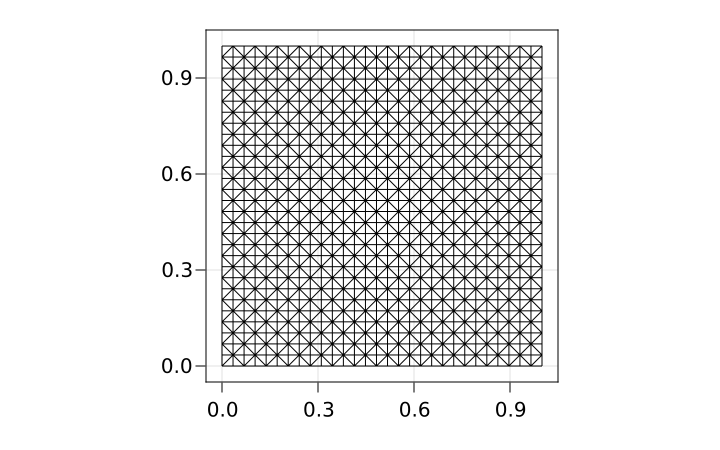

In [3]:
# Dimensional constants for the complex
w = 1
h = 1
num_points = 30
total_points = num_points*num_points

x_vals = range(0, w, length=num_points)
y_vals = range(0, h, length=num_points)

# Helper functions for keeping indexes straight
ind(x,y) = x + (y-1)*(num_points)
tri_ind(x,y) = x + (y-1)*(num_points-1)*2

# Initialize embedded complex
s = EmbeddedDeltaSet2D{Bool, Point{3, Float64}}()

# Define point coordinates for each point in the complex
points = Array{Point{3, Float64},1}(undef, total_points)
for x in 1:num_points
  for y in 1:num_points
    points[ind(x,y)]=Point{3,Float64}(x_vals[x],y_vals[y],0)
  end
end
add_vertices!(s, total_points, point=points)

# Define the connections between points (surfaces) as triangles that cover the surface
for y in 1:(num_points-1)
    for x in 1:(num_points-1)
        if (x+y) % 2 == 1
            glue_sorted_triangle!(s, ind(x,y), ind(x+1,y), ind(x,y+1))
            glue_sorted_triangle!(s, ind(x+1,y+1), ind(x,y+1), ind(x+1,y))
        else
            glue_sorted_triangle!(s, ind(x+1,y+1), ind(x,y+1), ind(x,y))
            glue_sorted_triangle!(s, ind(x,y), ind(x+1,y+1), ind(x+1,y))
        end
    end
end
orient_component!(s, 1, true)

# Draw the generated mesh
sd = EmbeddedDeltaDualComplex2D{Bool, Float64, Point{3,Float64}}(s)
subdivide_duals!(sd, Barycenter())
star0 = ⋆(0,sd)
fig, ax, du = wireframe(s)
ax.aspect = AxisAspect(1)
fig

## Add the physics

The physics is added to the tonti diagram in three parts:
- **Topological Equations**: These are defined by the specific complex and are composed of the coboundary operators
- **Temporal Equations**: These are the integration/derivation methods which connect the instance and interval time elements.
- **Constitutive Equations**: These are the relations which are unique to the system and which define its behavior

For this diffusion system, the constitutive equations are just the diffusion and mass conservation rules.

In [4]:
# Topological Equations
addSpace!(tda, s)

# Temporal Equations
addTime!(tda)


# Constitutive equations
const k = 0.003 # Diffusion constant

diffusion(diff) = ΔC -> diff*ΔC
mass_conv() = ∑ϕ->∑ϕ

addTransform!(tda, s, [:ΔCa], diffusion(k), [:ϕa])
addTransform!(tda, s, [:∑ϕa], mass_conv(), [:dCa]);

## Ideal Tonti Syntax
Ideally, the end-user will be able to use an interface like below to define the relationships between variables in a system. This allows the backend to perform optimization through symbolic rewriting, and allows for consideration to be made for certain conservation rules (relating to choice of time-stepping).

```julia
@tonti tda begin
  Ca::IP
  dCa::TP
  ΔCa::IL
  ∑ϕa::TS2
  ϕa::TL2

  ϕa  = k*ΔCa
  dCa = ∑ϕa
    
  Δm  = 0
end
```

## Generate vectorfield
Using the dependencies between variables, we are able to:
1. Find which variables define the state of the system
2. Generate a function which provides how a given state should change (vector field)

In [5]:
sim, data_syms = Tonti.vectorfield(tda, s)
data_syms

1-element Array{Pair{Symbol,Int64},1}:
 :Ca => 900

## 2D Diffusion
Once the vector field is evaluated, we are able to define our initial conditions (here a multivariate normal distribution), and pass them to the Julia DiffEq library for solving. Once this is done, we can visualize the results.

In [6]:
data_length = [data_syms[k][2] for k in keys(data_syms)]
du = zeros(sum(data_length))
u = [zeros(l) for l in data_length]

c_dist = MvNormal([0.5, 0.5], [0.25, 0.25])
u[1] .= gen_form(s, x->pdf(c_dist, [x[1],x[2]]))

prob = ODEProblem(sim, vcat(u...), (0,20.0))
sol = solve(prob, Tsit5(), progress=true);

## Results Visualization

The CombinatorialSpaces library integrates with the Makie graphics library to produce these plots.

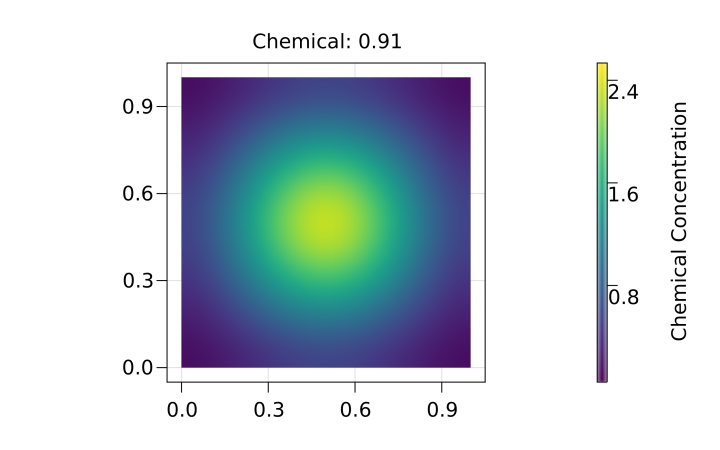

In [7]:
# Show the results at 7 seconds into the simulation
fig, ax, ob = mesh(s, color=sol(1))
ob.colorrange=(minimum(sol), maximum(sol))
cbar = fig[1,2] = Colorbar(fig, ob, label = "Chemical Concentration",
    ticklabelalign = (:center, :top), width=10)
ax.aspect = AxisAspect(1)
ax.title = "Chemical: $(round(sum(star0*sol(0))*100)/100)"
fig

In [8]:
# Plot a gif of the diffusion system
# Note that these are generated only on local runs of the notebook,
# and are not stored in the github repository because of size.

fig, ax, ob = mesh(s, color=sol(0), colorrange=(minimum(sol), maximum(sol)))
ax.aspect = AxisAspect(1)

framerate = 30
i_range = range(1, 20, length=150)
ax.title = "Chemical: $(round(sum(star0*sol(0))*100)/100)"
cbar = fig[1,2] = Colorbar(fig, ob, label = "Chemical Concentration",
    ticklabelalign = (:center, :top), width=10)

record(fig, "diffusion.gif", i_range; framerate = framerate) do i
  ob.color = sol(i)
  ax.title = "Chemical: $(round(sum(star0*sol(i))*100)/100)"
end

"diffusion.gif"

## 2D Diffusion w/ multiple chemical species

We are also able to generate multiple physics systems and then introduce interaction terms between these systems, resulting in a single unified simulator.

Here we will show how 3 diffusion systems can be combined along with the chemical reaction $A + E \to B + E$ as an interaction term between them

In [9]:
tdb = TontiDiagram(2, [:Cb =>:IP,  :dCb =>:TP,  :ΔCb=>:IL,
                       :∑ϕb=>:TS2, :ϕb=>:TL2]);
tde = TontiDiagram(2, [:Ce =>:IP,  :dCe =>:TP,  :ΔCe=>:IL,
                       :∑ϕe=>:TS2, :ϕe=>:TL2]);

addTransform!(tdb, [:ΔCb], diffusion(k), [:ϕb])
addTransform!(tdb, [:∑ϕb], mass_conv(), [:dCb]);
addTransform!(tde, [:ΔCe], diffusion(k), [:ϕe])
addTransform!(tde, [:∑ϕe], mass_conv(), [:dCe]);
addSpace!(tdb, s)
addTime!(tdb)
addSpace!(tde, s)
addTime!(tde)

tdab = disj_union(tda, tdb)
td = disj_union(tdab, tde);

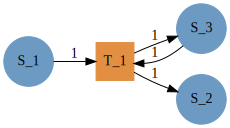

In [10]:
# A + E -> B + E
const rxn_rate = 1

petrinet = PetriNet(3,(1,3)=>(2,3))
rxn = AlgebraicPetri.vectorfield(petrinet)
temp_du = zeros(3)
reaction(u) = begin
    rxn(temp_du, u, [rxn_rate], 1)
    temp_du
end
addTransform!(td, [:Ca, :Cb, :Ce], reaction, [:∑ϕa, :∑ϕb, :∑ϕe]);
Graph(petrinet)

### Note:
Now we have 3 state variables, since we need concentrations of all chemicals for evaluating the system

In [11]:
sim, data_syms = Tonti.vectorfield(td, s)
data_syms

3-element Array{Pair{Symbol,Int64},1}:
 :Ca => 900
 :Cb => 900
 :Ce => 900

In [12]:
data_length = [data_syms[k][2] for k in keys(data_syms)]
du = zeros(sum(data_length))
u = [zeros(l) for l in data_length]

# Define two distributions of A and E on their own sides of the complex
ca_dist = MvNormal([0.25, 0.5], [0.2, 0.2])
ce_dist = MvNormal([0.75, 0.5], [0.2, 0.2])

u[1] .= gen_form(s, x->pdf(ca_dist, [x[1],x[2]]))
u[3] .= gen_form(s, x->pdf(ce_dist, [x[1],x[2]]))

prob = ODEProblem(sim, vcat(u...), (0,30.0))
sol = solve(prob, Tsit5(), progress=true);

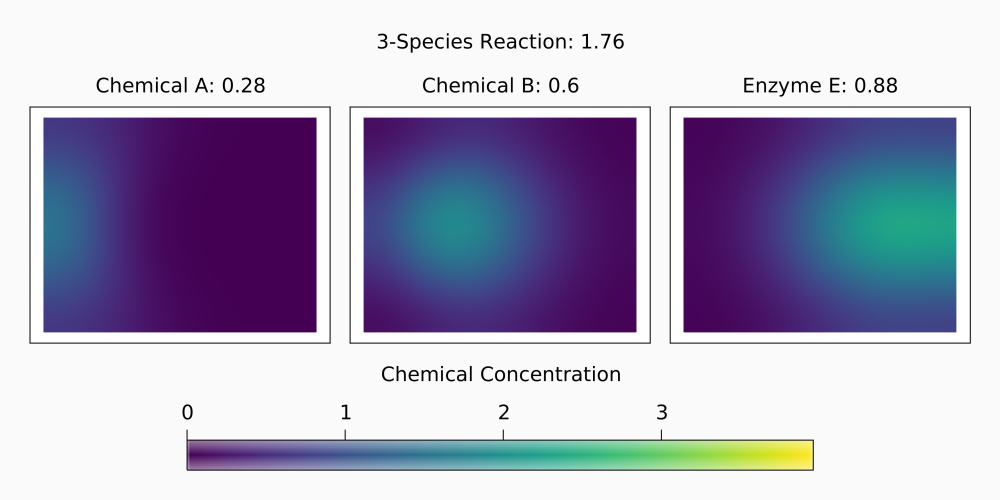

In [13]:
fig = Figure(resolution = (1000, 500), backgroundcolor = RGBf0(0.98, 0.98, 0.98))
crange = (minimum(sol), maximum(sol))
i = 5
axA = fig[1, 1] = Axis(fig, title = "Chemical A")
plA = mesh!(s, color=sol(i)[1:total_points], colorrange=crange)
axB = fig[1, 2] = Axis(fig, title = "Chemical B")
plB = mesh!(s, color=sol(i)[(1:total_points) .+ total_points], colorrange=crange)
axE = fig[1, 3] = Axis(fig, title = "Enzyme E")
plE = mesh!(s, color=sol(i)[(1:total_points) .+ (2*total_points)], colorrange=crange)
linkaxes!(axA, axB, axE)
hidedecorations!.([axA,axB,axE])

cbar = fig[2,1:3] = Colorbar(fig, plA, label = "Chemical Concentration", vertical = false)
cbar.height=30
cbar.width = Relative(2/3)
plA.colormap=:viridis
plB.colormap=:viridis
plE.colormap=:viridis

axA.title = "Chemical A: $(round(sum(star0*sol(i)[1:total_points])*100)/100)"
axB.title = "Chemical B: $(round(sum(star0*sol(i)[(1:total_points) .+ total_points])*100)/100)"
axE.title = "Enzyme E: $(round(sum(star0*sol(i)[(1:total_points) .+ (2*total_points)])*100)/100)"
supertitle = fig[0, :] = Label(fig, "3-Species Reaction: $(round(sum(star0*reshape(sol(i), total_points, 3))*100)/100)")
fig

In [14]:
framerate = 30
i_range = range(1, 30, length=600)

record(fig, "3_species.gif", i_range; framerate = framerate) do i
    plA.color = sol(i)[1:total_points]
    plB.color = sol(i)[(1:total_points) .+ total_points]
    plE.color = sol(i)[(1:total_points) .+ (2*total_points)]
    axA.title = "Chemical A: $(round(sum(star0*sol(i)[1:total_points])*100)/100)"
    axB.title = "Chemical B: $(round(sum(star0*sol(i)[(1:total_points) .+ total_points])*100)/100)"
    axE.title = "Enzyme E: $(round(sum(star0*sol(i)[(1:total_points) .+ (2*total_points)])*100)/100)"
    supertitle.text = "3-Species Reaction: $(round(sum(star0*reshape(sol(i), total_points, 3))*100)/100)"
end

"3_species.gif"

## Diffusion on an Imported Mesh
The tooling provided by `CombinatorialSpaces.jl` allows for us to import triangulated meshes from several common formats. We are then able to utilize the Tonti Diagram tooling to apply a physics to these meshes.

To demonstrate this, we will set up a physics simulation on the mesh of a cat. This simulation will demonstrate:
- **Heat Diffusion**: The cat is heated from the bottom of its paws, and diffusion of this heat across its body is simulated
- **Reversible Chemical Process**: The cat has a two-chemical reversible reaction over its body
- **Temperature-Dependent Rates**: The temperature impacts the rate and direction of the reaction
- **Temperature-Impacting Reactions**: The rate of reaction generates or uses heat (depending on direction), which impacts the heat at each location

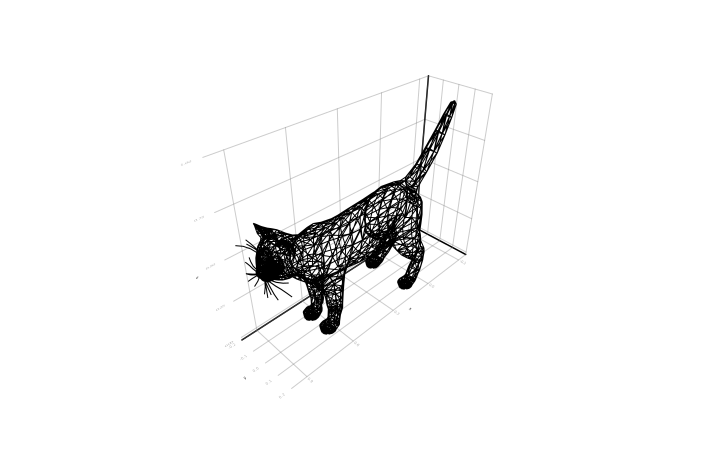

In [15]:
cat = EmbeddedDeltaSet2D("../visualization/cat.obj");

# Initialize the Tonti diagrams for each system
td_cat_tmp = TontiDiagram(2, [:C_T =>:IP,  :dC_T =>:TP,  :ΔC_T=>:IL,
                              :∑ϕ_T=>:TS2, :ϕ_T  =>:TL2]);
td_cat_wtr = TontiDiagram(2, [:C_w =>:IP,  :dC_w =>:TP,  :ΔC_w=>:IL,
                              :∑ϕ_w=>:TS2, :ϕ_w  =>:TL2]);
td_cat_vpr = TontiDiagram(2, [:C_v =>:IP,  :dC_v =>:TP,  :ΔC_v=>:IL,
                              :∑ϕ_v=>:TS2, :ϕ_v  =>:TL2]);

wireframe(cat)

In [16]:
# Define diffusion on each of these variables (each having its own constant of diffusion)
k_T = 5e-5
k_w = 1e-7
k_v = 1e-6


addTransform!(td_cat_tmp, [:ΔC_T], diffusion(k_T), [:ϕ_T])
addTransform!(td_cat_tmp, [:∑ϕ_T], mass_conv(), [:dC_T]);

addTransform!(td_cat_wtr, [:ΔC_w], diffusion(k_w), [:ϕ_w])
addTransform!(td_cat_wtr, [:∑ϕ_w], mass_conv(), [:dC_w]);

addTransform!(td_cat_vpr, [:ΔC_v], diffusion(k_v), [:ϕ_v])
addTransform!(td_cat_vpr, [:∑ϕ_v], mass_conv(), [:dC_v]);

for td in [td_cat_tmp, td_cat_wtr, td_cat_vpr]
  addSpace!(td, cat)
  addTime!(td)
end

# Merge Systems
td_cat_evp = disj_union(td_cat_tmp, td_cat_wtr)
td_cat = disj_union(td_cat_evp, td_cat_vpr);

In [17]:
using GLMakie
GLMakie.activate!()
# Adding fonts because the GLMakie default is error-prone
noto_sans = "assets/NotoSans-Regular.ttf"
noto_sans_bold = "assets/NotoSans-Bold.ttf"

"assets/NotoSans-Bold.ttf"

## Define the physics
Below we generate the reversible reaction using the tooling from `AlgebraicPetri.jl`.

We also show how how we have decided to make the reaction rates vary with temperature. While this current choice is only based on desired phenomenology, any relationship could be included.

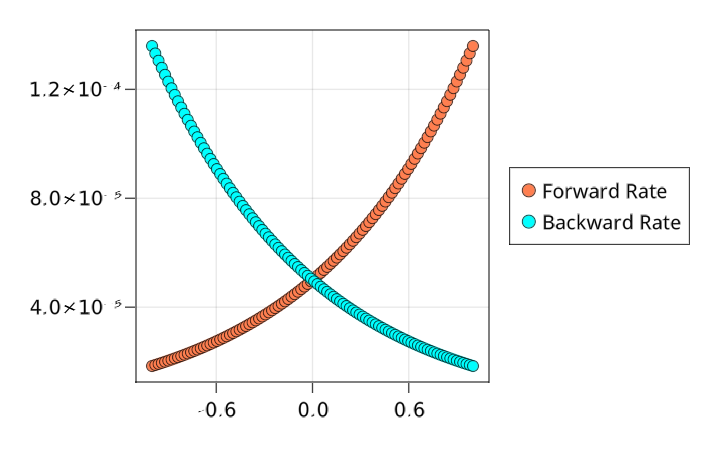

In [18]:
# Define constants for the reaction
rxn_const = 5e-5
equ_tmp = 0
endo_const = 1e-8

# Define reaction for evaporation and condensation
rxn = AlgebraicPetri.vectorfield(PetriNet(2,(1)=>(2), (2)=>(1)))

res = zeros(2)
reaction(u) = begin
  rxn(res, u[1:2], rxn_const*[exp(u[3]-equ_tmp), exp(equ_tmp - u[3])], 1)
  [res[1], res[2], (res[1]-res[2])*endo_const]
end

addTransform!(td_cat, [:C_w, :C_v, :C_T], reaction, [:∑ϕ_w, :∑ϕ_v, :∑ϕ_T]);

#Visualize result
temp_span = range(-1, 1, length=100)
fig, ax, r1 = plot(temp_span, rxn_const*exp.(temp_span.-equ_tmp), color=:coral)
r2 = plot!(temp_span, rxn_const*exp.(equ_tmp .- temp_span), color=:cyan)
fig[1,2] = Legend(fig, [r1, r2], ["Forward Rate", "Backward Rate"], labelfont = noto_sans)
fig

In [19]:
# Add boundary conditions to keep the feet as heat sources
feet_mask = gen_form(cat, x->x[3] < 0.02 ? 0 : 1);
addBC!(td_cat, :dC_T, ()->feet_mask)

19

In [20]:
# Generate initial conditions
feet_heat = gen_form(cat, x->x[3]<0.02 ? 1 : 0);
water = gen_form(cat, x->1e-3)
vapor = gen_form(cat, x->1e-3);

In [21]:
# Generate the combined vector field
sim, data_syms = Tonti.vectorfield(td_cat, cat)
data_syms

3-element Array{Pair{Symbol,Int64},1}:
 :C_T => 2247
 :C_w => 2247
 :C_v => 2247

In [22]:
# Solve the generated vector field for the initial conditions
prob = ODEProblem(sim, vcat(feet_heat, water, vapor), (0,150.0))
sol = solve(prob, Tsit5(), progress=true, progress_steps = 10);

## Visualize the results
In order to visualize these results, we generate both individual and combined animations of the temperature, water concentration, and vapor concentration.

In [23]:
col_min(x, r) = minimum(hcat(x.u...)[r, :])
col_max(x, r) = maximum(hcat(x.u...)[r, :])

fig, ax, ob = mesh(cat, color=sol(0)[(1:nv(cat))],
                        colorrange=(col_min(sol, 1:nv(cat)), col_max(sol, 1:nv(cat))))

framerate = 30
i_range = range(0, 150, length=300)

cbar = fig[1,2] = Colorbar(fig, ob, label = "Temperature",
    ticklabelalign = (:center, :top), width=10)
record(fig, "temp_diff.gif", i_range; framerate = framerate) do i
  ob.color = sol(i)[(1:nv(cat))]
  #ax.title = "Chemical: $(round(sum(sol(i))*100)/100)"
end


fig, ax, ob = mesh(cat, color=sol(0)[(1:nv(cat)).+nv(cat)],
                        colorrange=(col_min(sol, (1:nv(cat)).+nv(cat)), col_max(sol, (1:nv(cat)).+nv(cat))))
cbar = fig[1,2] = Colorbar(fig, ob, label = "Water Concentration",
    ticklabelalign = (:center, :top), width=10)
record(fig, "water_diff.gif", i_range; framerate = framerate) do i
  ob.color = sol(i)[(1:nv(cat)).+nv(cat)]
end


fig, ax, ob = mesh(cat, color=sol(0)[(1:nv(cat)).+2*nv(cat)],
                        colorrange=(col_min(sol, (1:nv(cat)).+2*nv(cat)), col_max(sol, (1:nv(cat)).+2*nv(cat))))
cbar = fig[1,2] = Colorbar(fig, ob, label = "Vapor Concentration",
    ticklabelalign = (:center, :top), width=10)
record(fig, "vapor_diff.gif", i_range; framerate = framerate) do i
  ob.color = sol(i)[(1:nv(cat)).+2*nv(cat)]
end

"vapor_diff.gif"

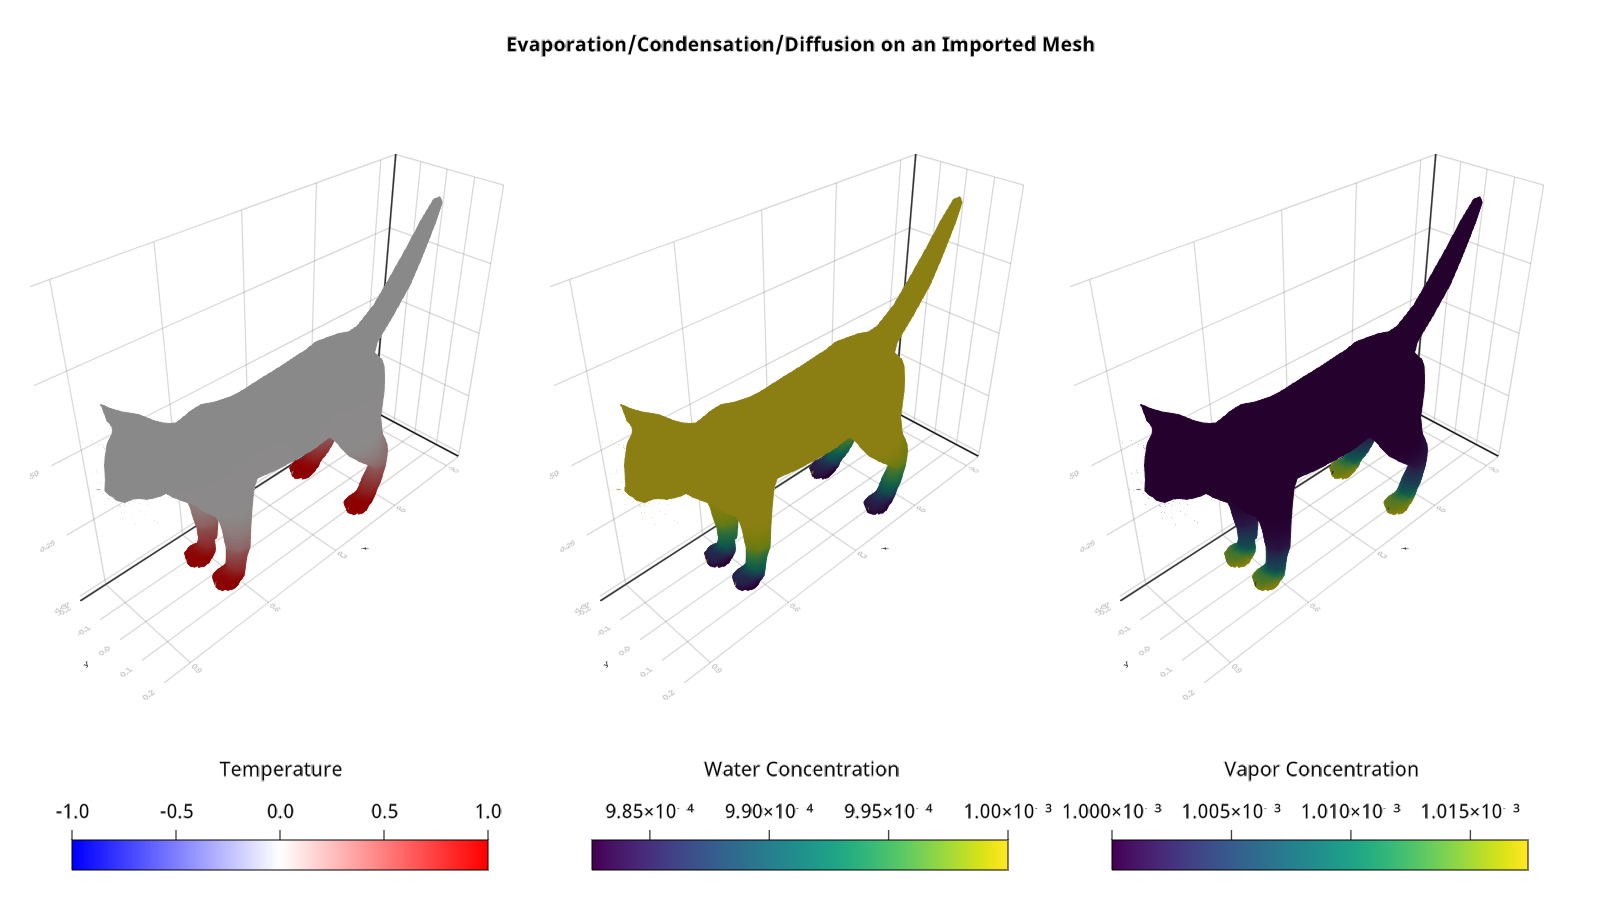

In [24]:
scene, layout = layoutscene(resolution = (1600, 900), font=noto_sans)
crange = (minimum(sol), maximum(sol))
i = 150
axA = layout[1, 1] = LScene(scene, scenekw = (camera = cam3d!, raw = false))
plA = mesh!(axA, cat, color=sol(i)[1:nv(cat)], colorrange=(-col_max(sol, 1:nv(cat)), col_max(sol, 1:nv(cat))))
axB = layout[1, 2] = LScene(scene, scenekw = (camera = cam3d!, raw = false))
plB = mesh!(axB, cat, color=sol(i)[(1:nv(cat)) .+ nv(cat)],
                      colorrange=(col_min(sol, (1:nv(cat)).+nv(cat)), col_max(sol, (1:nv(cat)).+nv(cat))))
axC = layout[1, 3] = LScene(scene, scenekw = (camera = cam3d!, raw = false))
plC = mesh!(axC, cat, color=sol(i)[(1:nv(cat)) .+ (2*nv(cat))], 
                      colorrange=(col_min(sol, (1:nv(cat)).+2*nv(cat)), col_max(sol, (1:nv(cat)).+2*nv(cat))))
#linkaxCs!(axA, axB, axC)
#hidedecorations!.([axA,axB,axC])

cbarA = layout[2,1] = Colorbar(scene, plA, label = "Temperature", vertical = false)
cbarB = layout[2,2] = Colorbar(scene, plB, label = "Water Concentration", vertical = false)
cbarC = layout[2,3] = Colorbar(scene, plC, label = "Vapor Concentration", vertical = false)
cbarA.height= cbarB.height = cbarC.height = 30
cbarA.width = cbarB.width = cbarC.width = Relative(5/6)
plA.colormap=:bwr
#=plB.colormap=:tab20
plC.colormap=:tab20=#

#=axA.title = "Chemical A: $(round(sum(sol(i)[1:nv(cat)])*100)/100)"
axB.title = "Chemical B: $(round(sum(sol(i)[(1:nv(cat)) .+ nv(cat)])*100)/100)"
axC.title = "Enzyme E: $(round(sum(sol(i)[(1:nv(cat)) .+ (2*nv(cat))])*100)/100)"=#
supertitle = layout[0, :] = Label(scene, "Evaporation/Condensation/Diffusion on an Imported Mesh", font=noto_sans_bold)
scene

In [25]:
framerate = 30
i_range = range(0, 100, length=300)

record(scene, "cat_evap.gif", i_range; framerate = framerate) do i
    plA.color = sol(i)[1:nv(cat)]
    plB.color = sol(i)[(1:nv(cat)) .+ nv(cat)]
    plC.color = sol(i)[(1:nv(cat)) .+ (2*nv(cat))]
    supertitle.text = "Evaporation/Condensation/Diffusion on an Imported Mesh"
end

"cat_evap.gif"